In [1]:
import csv
import re
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.convolution import convolve, Gaussian2DKernel
import astropy.constants as const
from matplotlib import colors
import matplotlib.cm as cm
import scipy.misc
import scipy.stats as sta
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')
import plotly.graph_objects as go
import plotly
from astropy.cosmology import WMAP9 as cosmo
from pandas.core.frame import DataFrame
from scipy.optimize import curve_fit
from scipy import integrate
import os

#1pixel=0.25arcsec

In [2]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm
#绘制天区图像用

def calculate_flux_per_frequency(mag):
    flux_density=10**((48.6+mag)/(-2.5))
    return flux_density

def calculate_flux_per_wavelength(mag,corresponding_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    return intensity

def calculate_flux(mag,corresponding_lambda,delta_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    return flux

def calculate_distance(redshift):
    distance=redshift*3e5/70
    distance=distance*9.4607e17
    distance=distance*3.2616e6
    return(distance)

def calculate_continuum_flux_density(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    return continuum_flux_density

def calculate_continuum_subtracted_line_flux(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    continuum_subtracted_line_flux=flux_nb-continuum_flux_density*delta_lambda_nb
    return continuum_subtracted_line_flux

def calculate_SB(mag,corresponding_lambda,delta_lambda,area):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    surface_brightness=flux/(area*0.25*0.25)
    return surface_brightness
    
# unit： erg per second per quare centimeter per suqare arcsec

def choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return False
    return True

def wrong_choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return True
    return False

In [3]:
def show_nebula(img1,img2,img3,x,y,size):
    norm1 = Scaleimgconverter(img1)
    norm2 = Scaleimgconverter(img2)
    norm3 = Scaleimgconverter(img3)
    center=[np.array([x],float),np.array([y],float)]
    cutout1=Cutout2D(data, center,30, wcs = WCS(header))
    cutout2=Cutout2D(data2, center,30, wcs = WCS(header))
    cutout3=Cutout2D(datacut, center,30, wcs = WCS(header))
  
    x = x.astype(int)
    y = y.astype(int)
    x1=x-size
    x2=x+size
    y1=y-size
    y2=y+size
    fig = plt.figure()
    ax = plt.subplot(131,projection=cutout1.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img1[y1:y2,x1:x2],norm=norm1,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')
    
    fig = plt.figure()
    ax = plt.subplot(132,projection=cutout2.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img2[y1:y2,x1:x2],norm=norm2,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

    fig = plt.figure()
    ax = plt.subplot(133,projection=cutout3.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img3[y1:y2,x1:x2],norm=norm3,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

In [4]:
with open("BOSS0112_NB.csv",'w+',newline='') as csvfile:#创建一个新的csv文件
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('0112nb_d1.0.cat','r',encoding = 'utf-8') as f:#打开那个.cat文件
        linelist = f.readlines()[13:]#从第十三行写起
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()#split（）函数，按括号中的内容分割，strip函数，移除头尾指定的字符
            spamwriter.writerow(line_list)

In [5]:
with open("BOSS0112_Bw.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('0112bw_d1.0.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [6]:
SDSS6=pd.read_csv("SDSS6.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
BOSS_Bw=pd.read_csv("BOSS0112_Bw.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])
#index_col=False
BOSS_NB=pd.read_csv("BOSS0112_NB.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])#读取哪几列

In [7]:
SDSS6=pd.concat([SDSS6,(SDSS6['umag']-0.8116*(SDSS6['umag'] - SDSS6['gmag']) + 0.1313)],axis=1)#计算bmag
#axis： 需要合并链接的轴，0是行，1是列 

SDSS6.columns=['_RAJ2000', '_DEJ2000',  'RA_ICRS',  'DE_ICRS',     'mode',   'q_mode',\
          'class',   'SDSS12', 'm_SDSS!2',  'ObsDate',        'Q',     'umag',\
         'e_umag',     'gmag',   'e_gmag',     'rmag',   'e_rmag',     'imag',\
         'e_imag',     'zmag',   'e_zmag',      'zsp',      'zph',    'e_zph',\
          '<zph>',          'bmag']
#bmag是到这儿才加上来的

In [8]:
coord_sdss=SkyCoord(ra=SDSS6['_RAJ2000']*u.degree, dec=SDSS6['_DEJ2000']*u.degree)
#不乘u.degree会报错，但为什么也不是很清楚
coord_bw=SkyCoord(ra=BOSS_Bw['ALPHA_J2000']*u.degree, dec=BOSS_Bw['DELTA_J2000']*u.degree)
coord_nb=SkyCoord(ra=BOSS_NB['ALPHA_J2000']*u.degree, dec=BOSS_NB['DELTA_J2000']*u.degree)

In [9]:
idx, d2d, d3d = coord_sdss.match_to_catalog_sky(coord_bw)

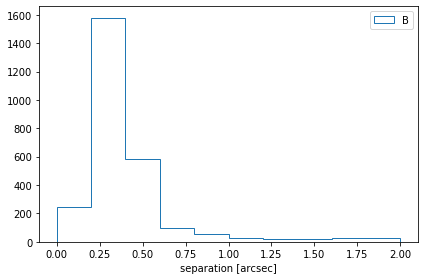

In [10]:
# separation
plt.subplot(111)
plt.hist(d2d.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.legend('Bw')
plt.tight_layout()
plt.show()

In [11]:
index = np.where((d2d < Angle('0d00m0.75s'))&(SDSS6['bmag'] < 20)&(SDSS6['bmag'] > 16.5))#把其中符合条件的摘出来，即用index来标出距离足够小的object
idx=idx[index]#可以认为是同一个object的点的indices

SDSS6_RAJ2000=SDSS6._RAJ2000.data.obj#SDSS的RA
SDSS6_DEJ2000=SDSS6._DEJ2000.data.obj#SDSS的DEC
SDSS6_bmag=SDSS6.bmag.data.obj#SDSS的bmag
BOSS_Bw_list=BOSS_Bw.MAG_APER.data.obj#BOSS的Bw Mag

BOSS_Bw_list_standard=BOSS_Bw.MAG_APER.data.obj[idx]#BOSS中可被认为是相同object的部分
SDSS6_bmag_standard=SDSS6_bmag[index]#SDSS中可被认为是相同object的部分

zeropoint_bw=SDSS6_bmag_standard-BOSS_Bw_list_standard
zeropoint_bw=sigma_clip(zeropoint_bw, sigma=3, iters=10)

zp_bw=np.mean(zeropoint_bw)#Bw的zeropoint
zp_std_bw=np.std(zeropoint_bw)#Bw的standard deviation

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version



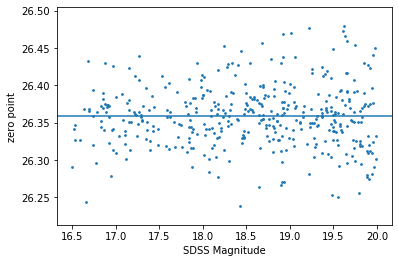

Bw的zeropoint为 26.358608990291263
Bw的standard deviation为 0.04123711292847757


In [12]:
plt.axhline(zp_bw)
plt.xlabel('SDSS Magnitude')
plt.ylabel('zero point')
plt.scatter(x=SDSS6_bmag_standard,y=zeropoint_bw,s=3)
#plt.axis([16.5, 20.5, 24, 26])
plt.show()

print('Bw的zeropoint为',zp_bw)
print('Bw的standard deviation为',zp_std_bw)

In [13]:
BOSS_Bw=pd.concat([BOSS_Bw,BOSS_Bw.MAG_APER+zp_bw],axis=1)
BOSS_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']
#重写Bw的dataframe，把加了zp的真实mag扔进去，新的一列就叫standard_mag

In [14]:
idx_nb, d2d_nb, d3d_nb = coord_nb.match_to_catalog_sky(coord_bw)

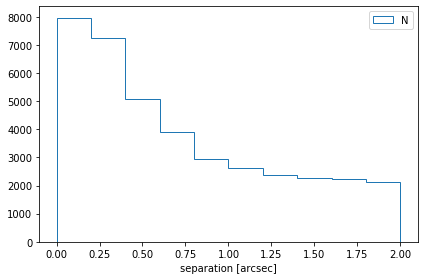

In [15]:
plt.subplot(111)
plt.hist(d2d_nb.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.legend('NB')
plt.tight_layout()

In [16]:
index_nb = np.where(d2d_nb < Angle('0d0m02s'))
idx_nb=idx_nb[index_nb]

In [17]:
BOSS_NB_match = BOSS_NB.MAG_APER.data.obj[index_nb]
#这是全部的可以与NB中对应成功的NB中的源的现在的nb_magnitude,包括galaxy和star
index_zp = np.where((BOSS_NB_match < 5) &(BOSS_NB_match > 0))
#这是全部可以用来计算zeropoint的NB的点

mid=BOSS_Bw.standard_mag.data.obj[idx_nb]
mag_bw_standard_select=mid[index_zp]#这里面写出来的则是与下面那个对应的bw中的标准的magnitude
mag_nb_standard_select=BOSS_NB_match[index_zp]#这里面写出来是标准的nb的magnitude

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [18]:
zeropoint_nb=mag_bw_standard_select-mag_nb_standard_select
zeropoint_nb=sigma_clip(zeropoint_nb, sigma=1, iters=10)

zp_nb=np.mean(zeropoint_nb)
zp_std_nb=np.std(zeropoint_nb)

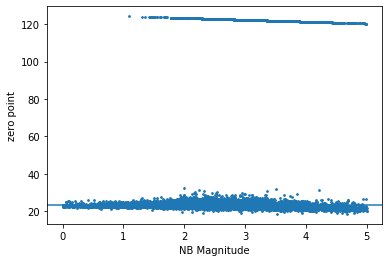

NB的zeropoint为 22.99458096831324
NB的standard deviation为 0.004210861862599072


In [19]:
plt.axhline(zp_nb)
plt.xlabel('NB Magnitude')
plt.ylabel('zero point')
plt.scatter(x=mag_nb_standard_select,y=mag_bw_standard_select-mag_nb_standard_select,s=3)
#plt.axis([0,5.5,18,30])
plt.show()

print('NB的zeropoint为',zp_nb)
print('NB的standard deviation为',zp_std_nb)

In [20]:
BOSS_NB=pd.concat([BOSS_NB,BOSS_NB.MAG_APER+zp_nb],axis=1)
BOSS_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

In [21]:
flux_bw=[]
flux_nb=[]

for i in range(len(BOSS_Bw.standard_mag.data.obj)):#对里面所有的点，求bw flux
    flux_bw.append(calculate_flux(BOSS_Bw.standard_mag.data.obj[i],4135,1278))
    
for i in range(len(BOSS_NB.standard_mag.data.obj)):#对里面所有的点,求nb flux
    flux_nb.append(calculate_flux(BOSS_NB.standard_mag.data.obj[i],4030,45))

flux_bw=DataFrame(flux_bw)#转换格式
flux_nb=DataFrame(flux_nb)#转换格式

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [22]:
BOSS_Bw=pd.concat([BOSS_Bw,flux_bw],axis=1)
BOSS_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw']

BOSS_NB=pd.concat([BOSS_NB,flux_nb],axis=1)
BOSS_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb']

In [23]:
Bw_1=pd.DataFrame()

Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.X_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.Y_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.ALPHA_J2000.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.DELTA_J2000.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.FLUX_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.FLUXERR_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.MAG_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.MAGERR_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.FLAGS.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.NITER_MODEL.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.ISOAREA_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.ISOAREAF_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.standard_mag.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS_Bw.flux_bw.data.obj[idx_nb])],axis=1)
Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will 

In [24]:
NB_1=pd.DataFrame()


NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.X_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.Y_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.ALPHA_J2000.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.DELTA_J2000.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.FLUX_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.FLUXERR_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.MAG_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.MAGERR_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.FLAGS.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.NITER_MODEL.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.ISOAREA_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.ISOAREAF_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.standard_mag.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS_NB.flux_nb.data.obj[index_nb])],axis=1)
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will 

In [25]:
F_bw=Bw_1.flux_bw.data.obj
F_nb=NB_1.flux_nb.data.obj

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [26]:
cont_flux_per_wavelength=[]
for i in range(len(F_bw)):
    #cont_flux_per_wavelength.append((F_bw[i]-F_nb[i])/(1278-45))
    cont_flux_per_wavelength.append(calculate_continuum_flux_density(F_bw[i],F_nb[i],1278,45))
    
#得到了continuum flux density,下面要反求magnitude

In [27]:
Bw_1=pd.concat([Bw_1,DataFrame(cont_flux_per_wavelength)],axis=1)
Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_wavelength']

NB_1=pd.concat([NB_1,DataFrame(cont_flux_per_wavelength)],axis=1)
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_wavelength']

In [28]:
minus_number=[]
for i in range(len(cont_flux_per_wavelength)):
    if (cont_flux_per_wavelength[i]<0):
        #print(cont_flux_per_wavelength[i])
        minus_number.append(i)

In [29]:
Bw_1.drop(minus_number,inplace=True)
NB_1.drop(minus_number,inplace=True)
Bw_1.reset_index(drop=True, inplace=True)
NB_1.reset_index(drop=True, inplace=True)

In [30]:
Bw_1=pd.concat([Bw_1,Bw_1.cont_flux_per_wavelength*(4135**2)/(3e8*1e10)],axis=1)
NB_1=pd.concat([NB_1,NB_1.cont_flux_per_wavelength*(4135**2)/(3e8*1e10)],axis=1)

Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_wavelength','cont_flux_per_frequency']
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_wavelength','cont_flux_per_frequency']

In [31]:
cont_bw=[]
for i in range(len(Bw_1)):
    cont_bw.append((-2.5*math.log(Bw_1.cont_flux_per_frequency.data.obj[i],10)-48.6))

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [32]:
Bw_1=pd.concat([Bw_1,DataFrame(cont_bw)],axis=1)
NB_1=pd.concat([NB_1,DataFrame(cont_bw)],axis=1)
Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']

In [33]:
bw_sub_nb=[]
for i in range(len(NB_1)):
    bw_sub_nb.append(Bw_1.standard_mag.data.obj[i]-NB_1.standard_mag.data.obj[i])

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version



/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



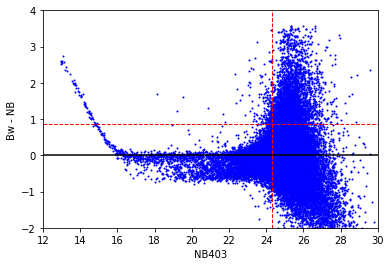

In [34]:
plt.scatter(NB_1.standard_mag.data, bw_sub_nb, color = 'b', s=1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.87, color='r', linestyle='--', linewidth = 1)
plt.axvline(24.3, color='r', linestyle='--', linewidth = 1)
plt.axis([12,30,-2,4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [35]:
w = WCS('BOSS0112_Bw_cut.fits')
data,header=fits.getdata('BOSS0112_Bw_cut.fits',header=True)
data2,header2=fits.getdata('BOSS0112_NB_cut.fits',header=True)

datacut=10**((zp_bw - zp_nb)/2.5) * data2-data
#datacut=10**((zp_bw - zp_nb)/2.5) * data2-data2
dataadd=10**((zp_bw - zp_nb)/2.5) * data2+data

norm = Scaleimgconverter(datacut)

lenx=len(data[0])
leny=len(data)
#最后两行暂时不知道有啥用

In [36]:
index_candidate=[]
for i in range(len(Bw_1)):
    if (Bw_1.standard_mag.data.obj[i]-NB_1.standard_mag.data.obj[i] > 0.87) \
        & (NB_1.standard_mag.data.obj[i]< 24.3):
        if choose(datacut,NB_1.X_IMAGE.data.obj[i],NB_1.Y_IMAGE.data.obj[i],-10,40):
            index_candidate.append(i)

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [37]:
Bw_2=pd.DataFrame()

Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.X_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.Y_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.ALPHA_J2000.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.DELTA_J2000.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.FLUX_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.FLUXERR_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.MAG_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.MAGERR_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.FLAGS.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.NITER_MODEL.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.ISOAREA_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.ISOAREAF_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.standard_mag.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.flux_bw.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.cont_flux_per_frequency.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.cont_flux_per_wavelength.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.cont_bw.data.obj[index_candidate])],axis=1)
Bw_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will 

In [38]:
NB_2=pd.DataFrame()

NB_2=pd.concat([NB_2,DataFrame(NB_1.X_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.Y_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.ALPHA_J2000.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.DELTA_J2000.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.FLUX_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.FLUXERR_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.MAG_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.MAGERR_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.FLAGS.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.NITER_MODEL.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.ISOAREA_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.ISOAREAF_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.standard_mag.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.flux_nb.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.cont_flux_per_frequency.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.cont_flux_per_wavelength.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.cont_bw.data.obj[index_candidate])],axis=1)
NB_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will 

In [39]:
NB_2=pd.concat([NB_2,NB_2.flux_nb-(NB_2.cont_flux_per_wavelength*45)],axis=1)
Bw_2=pd.concat([Bw_2,NB_2.flux_nb-(NB_2.cont_flux_per_wavelength*45)],axis=1)

Bw_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux']
NB_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux']

#计算 line flux 没啥问题好吧

In [40]:
#distance=cosmo.comoving_distance((4030-1215.7)/1215.7).value*3.2615637771418798291*9.46*1e23*(4030-1215.7)/1215.7
distance=math.sqrt(2.27e43/(1e-15*4*math.pi))
#distance=calculate_distance(2.3)
Bw_2=pd.concat([Bw_2,DataFrame(4*math.pi*distance**2*Bw_2.line_flux.data.obj)],axis=1)
NB_2=pd.concat([NB_2,DataFrame(4*math.pi*distance**2*NB_2.line_flux.data.obj)],axis=1)
#emitter_1=pd.concat([emitter_1,DataFrame(4*math.pi*distance**2*emitter_1.flux_bw.data.obj)],axis=1)

Bw_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux','luminosity']
NB_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux','luminosity']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version



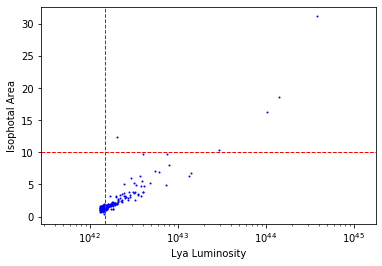

In [41]:
plt.semilogx()
plt.scatter(NB_2.luminosity,NB_2.ISOAREA_IMAGE*(0.0625), color = 'b', s=1)
plt.axhline(10, color='r', linestyle='--', linewidth = 1)
plt.axvline(1.5e42, color='r', linestyle='--', linewidth = 1)
plt.xlabel('Lya Luminosity')
plt.ylabel('Isophotal Area')
plt.show()

In [42]:
lya=pd.DataFrame()
for i in range(len(NB_2)):
    #if (NB_2.luminosity.data.obj[i]> 1.5e43) and ((NB_2.ISOAREA_IMAGE.data.obj[i]*(0.0625))> 15):
    if (NB_2.luminosity.data.obj[i]> 1.5e42) and ((NB_2.ISOAREAF_IMAGE.data.obj[i]*(0.0625))> 10):
        lya=pd.concat([lya,NB_2.loc[i:i]],ignore_index = True)

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [43]:
lya=pd.concat([lya,DataFrame(calculate_SB(lya.cont_bw.data.obj,4135,1278,lya.ISOAREA_IMAGE.data.obj*0.0625))],axis=1)

lya.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux','luminosity','surface_brightness']
#???关于用到的surface brightness的delta_lambda什么的？

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [44]:
print(lya)

     X_IMAGE    Y_IMAGE  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER  \
0    85.6388  1300.6395    18.406004    34.806180   0.924956      1.450588   
1  5382.0918  1770.2578    17.957921    34.838359  33.011860      8.661927   
2  6356.0068  1842.9869    17.875496    34.843151   1.734542      1.985991   
3  4420.9463  3032.5698    18.038961    34.926219  23.786360      7.352682   
4  3805.6992  3248.4016    18.091033    34.941307  88.293880     14.165800   
5  3967.5396  4565.5010    18.077074    35.032748   6.894901      3.958821   
6  3050.9314  6518.5649    18.154570    35.168493   0.470186      1.034713   

   MAG_APER  MAGERR_APER  FLAGS  NITER_MODEL  ISOAREA_IMAGE  ISOAREAF_IMAGE  \
0    0.0847       1.7031      0           34            156             254   
1   -3.7967       0.2850      0           64            298             334   
2   -0.5980       1.2434      2           43            156             183   
3   -3.4408       0.3357      0           26            259

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Series.data is deprecated and will be removed in a future version



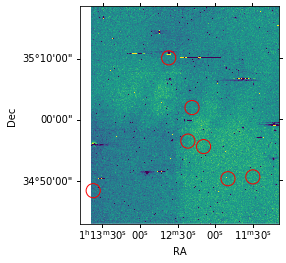

<Figure size 432x288 with 0 Axes>

In [45]:
ax = plt.subplot(projection=WCS(header))
fig = plt.figure()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(datacut, origin='lower',norm=norm,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')
ax.scatter(lya.X_IMAGE.data.obj, lya.Y_IMAGE.data.obj, color='', marker='o', edgecolors='r', s=200)

In [46]:
def Gaussian2D(r, sigma):
    return (1/(2*np.pi*sigma**2))*np.exp(-r**2/2/sigma**2)

def f_i(i, x, sigma):
    x1 = np.delete(x, i, axis=1)
    r = np.sqrt((x[0][i]-x1[0])**2 + (x[1][i]-x1[1])**2)
    Sum = np.sum(Gaussian2D(r, sigma))
    return Sum

def Likelyhood(x, sigma):
    list = [f_i(i, x, sigma) for i in range(len(x[0]))]
    Prod = np.prod(list)
    return Prod

In [47]:
hdu1 = fits.open('BOSS0112_Bw_cut.fits')[0]
wcs1 = WCS(hdu1.header)#; hdu1.close()

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



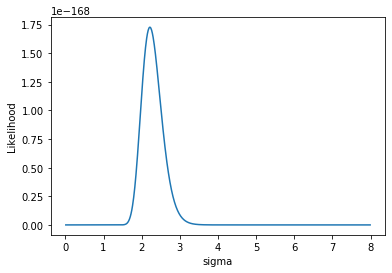

sigma is 2.3000000000000003 [arcmin]


In [48]:
ra, dec = wcs1.all_pix2world(NB_2.X_IMAGE.data.obj, NB_2.Y_IMAGE.data.obj,1)
emitter=np.vstack([60*ra, 60*dec])#把度转换成arcmin

step = 0.01
sigma = np.arange(step, 8, step)
Lh = [Likelyhood(emitter, s) for s in sigma]
plt.plot(sigma,Lh)
# plt.semilogy()
plt.xlabel('sigma')
plt.ylabel('Likelihood')
plt.show()

Sigma = Lh.index(max(Lh))*step+0.1
print('sigma is {}'.format(Sigma),'[arcmin]')
#求出做高斯分布的sigma

In [49]:
len_ra=wcs1.array_shape[0]*0.25/60
len_dec=wcs1.array_shape[1]*0.25/60

area=len_ra*len_dec
print(area,'arcmin**2')
#求整个field的面积，0.25是单个pixel对应的arcsec长度,再除60就是arcmin的长度了

1097.4295312499999 arcmin**2


In [50]:
print(len_ra)
print(len_dec)

35.5875
30.8375


In [51]:
ave_density=len(NB_2)/area
print('average density:',ave_density)

average density: 0.1713094049746076


In [52]:
binwidth = 100# sampling step
xx, yy = np.meshgrid(np.arange(0, wcs1.array_shape[0], binwidth), np.arange(0, wcs1.array_shape[1], binwidth))
#这一步就是分成100个区域-----一万个？貌似是一万个
ra_xx, dec_yy = wcs1.all_pix2world(xx+binwidth/2, yy+binwidth/2, 1)
#把这几个区域的中心做出来，一开始是用pixel的x和y值表示的，然后用wcs1.all_pix2world转化成用ra与dec表示
ra_xx, dec_yy = 60*ra_xx, 60*dec_yy
#再乘60，单位变成arcmin

f = [Gaussian2D(np.sqrt((ra_xx - emitter[0, i])**2 + (dec_yy - emitter[1, i])**2), Sigma) for i in range(len(emitter[0]))]
#这样做出来的f中的每一行，都是1个emitter对于1w个天区做高斯平滑后得到的单独个数分布

f1 = (np.sum(f, axis=0)/abs(ra_xx[0, 1]-ra_xx[0, 0])/abs((dec_yy[1, 0]-dec_yy[0, 0]))-ave_density)/ave_density
f = np.sum(f, axis=0)/abs(ra_xx[0, 1]-ra_xx[0, 0])/abs((dec_yy[1, 0]-dec_yy[0, 0]))


In [53]:
print(f1)

[[-0.92927399 -0.92622092 -0.924707   ... -0.98284075 -0.99091126
  -0.99540573]
 [-0.89449452 -0.88996014 -0.8878694  ... -0.98102998 -0.98994228
  -0.99491052]
 [-0.84743641 -0.84083489 -0.83791951 ... -0.97957346 -0.98915339
  -0.99450204]
 ...
 [ 1.84422367  2.01865723  2.0738274  ... -0.95326264 -0.97352745
  -0.98567352]
 [ 1.96133113  2.14245048  2.1991203  ... -0.95880179 -0.97670276
  -0.98740951]
 [ 2.0426564   2.23183481  2.29362545 ... -0.96452005 -0.97999638
  -0.98921721]]


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:251: UserWarning:

The following kwargs were not used by contour: 'lw'

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning:

The following kwargs were not used by contour: 'lw'

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version



[0, 8500, 0, 7400]

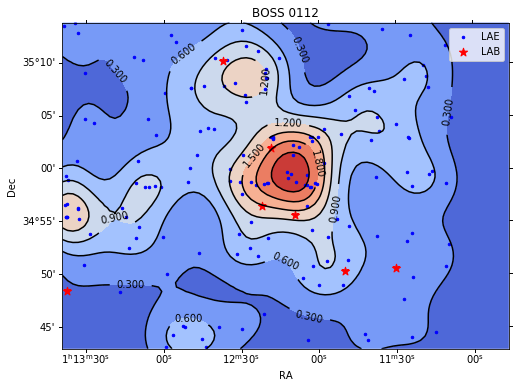

In [54]:
fig = plt.figure(figsize=(8,6))

ax = fig.gca(projection=wcs1)

cfset = ax.contourf(xx, yy, f, cmap='coolwarm', lw=1)
cset = ax.contour(xx, yy, f, colors='k', lw=1)

ax.scatter(NB_2.X_IMAGE.data.obj, NB_2.Y_IMAGE.data.obj, marker='.', color='blue', s=25, label='LAE')
ax.scatter(lya.X_IMAGE.data.obj, lya.Y_IMAGE.data.obj, marker='*', color='r', s=75, label='LAB')
ax.legend()

ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

plt.title('BOSS 0112')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


plt.axis([xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]])

In [55]:
blob=pd.DataFrame(columns = ['density'])
for i in range(len(lya)):
    new={'density':f1[int((lya.Y_IMAGE.data.obj[i]/100)),int((lya.X_IMAGE.data.obj[i]/100))]}
    blob=blob.append(new,ignore_index=True)

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version



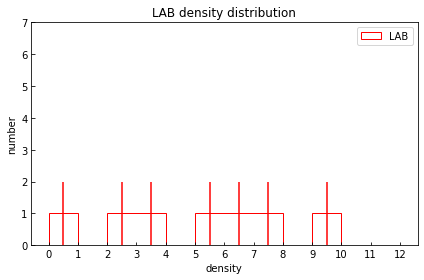

In [56]:
binwidth = 1

x = np.arange(0,12,1)
y = np.histogram(blob['density'], bins=np.arange(0,13,1))[0]

X = np.delete(np.vstack([x, y]), np.where(y==0) ,axis=1)
error = np.sqrt(X[1])


plt.hist(blob['density'], histtype='step', bins=np.arange(0,13,1), color='r')
plt.legend(['LAB'])
plt.errorbar(X[0]+0.5, X[1], fmt='None', yerr=error, ecolor='r')
plt.xlabel('density')
plt.ylabel('number')
plt.title('LAB density distribution')

new_ticks = np.linspace(0,12,13)
new_ticks2 = np.linspace(0,7,8)
plt.xticks(new_ticks)
plt.yticks(new_ticks2)

plt.tight_layout()
plt.show()

In [57]:
redshift_z=((4030-1215.7)/1215.7)
radii_z=cosmo.comoving_distance(redshift_z)#半径
angle_ra=len_ra/60
angle_dec=len_dec/60

length_ra=(angle_ra/180)*np.pi*radii_z
length_dec=(angle_dec/180)*np.pi*radii_z
area_field=length_ra*length_dec

velB= (cosmo.comoving_distance(redshift_z+45/2/1215.7)-cosmo.comoving_distance(redshift_z-45/2/1215.7))

volume=velB*area_field

binwidth = 0.2#luminosity每隔10e0.2划分一个bin

mag = np.log10(NB_2['luminosity'])

exponent=np.arange(binwidth*(min(mag)//binwidth-1), binwidth*(max(mag)//binwidth+1), binwidth)

y_lumi_func=np.histogram(mag, bins=exponent)[0]/volume.value
#数密度,即y轴坐标

x_lumi_func = np.power(10,np.arange(binwidth*(min(mag)//binwidth-1)+0.1, binwidth*(max(mag)//binwidth+1)-0.1, binwidth))
#x轴坐标来了！这里要注意一下把它变成和y轴一样多的，就是取两个区间中间的值！

lumi_func = np.delete(np.vstack([x_lumi_func, y_lumi_func]), np.where(y_lumi_func==0) ,axis=1)

error = np.sqrt(lumi_func[1]*volume.value)/volume.value#误差
error = np.sqrt(lumi_func[1]*volume.value)/volume.value#误差

def LuminoFunc(L, phi_star, L_star, alpha):
    return (phi_star)*np.power((L/L_star),alpha)*np.exp(-L/L_star)
#luminosity function的定义

param_bounds =([10**-7., 10**40., -2], [1, 10**44., -1.0])

popt_1, pcov_1 = curve_fit(LuminoFunc, lumi_func[0], lumi_func[1], p0=[10**(-4), 10**42.4, -1.3], bounds=param_bounds, maxfev=50000)


In [58]:
phi_star = popt_1[0]; L_star = popt_1[1]; alpha = popt_1[2]
print('phi*=', phi_star)
print('L*=', L_star)
print('alpha=', alpha)

xvals = np.linspace(10**42, 10**43,200)
yvals = LuminoFunc(xvals, phi_star, L_star, alpha)

#phi_star0, L_star0, alpha0 = 0.0005, 10**42.33, -1.65 #constant at z=2.3
#phi_star0, L_star0, alpha0 = 10**(-2.86), 10**42.33, -1.65 #constant at z=2.3
phi_star0, L_star0, alpha0 = 10**(-2.86), 10**42.33, -1.65 #constant at z=2.3
#phi_star0, L_star0, alpha0 = 10**(-3.15), 10**42.82, -1.65 #constant at z=2.3
v, err = integrate.quad(LuminoFunc, 0.65, 1000, args=(phi_star0, L_star0, alpha0)) # N_field
# print('err=',err)
# v = v * 15**3; print('random field Lya number density:', v, '/Mpc3')

phi*= 0.0004632758393704182
L*= 2.511886431509572e+42
alpha= -1.3000000142605954


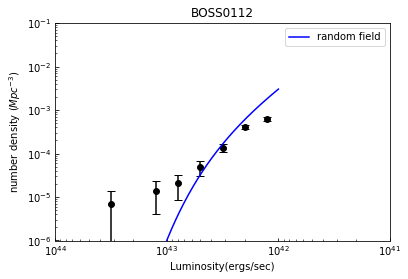

In [59]:
fig,ax = plt.subplots()
plt.semilogx()
plt.semilogy()

plt.scatter(lumi_func[0], lumi_func[1], color = 'black', edgecolors='black', marker='o', s=35)
plt.errorbar(lumi_func[0], lumi_func[1], fmt='None', yerr=error, ecolor='black', capsize=4)
plt.plot(xvals, LuminoFunc(xvals, phi_star0, L_star0, alpha0), color='b', label='random field')

ax.set_xlim(10e43,10e40)
ax.set_ylim(10e-7,10e-2)

ax.invert_xaxis()

plt.title('BOSS0112')
plt.xlabel('Luminosity(ergs/sec)')
plt.ylabel('number density ($Mpc^{-3}$)')
plt.legend()

In [60]:
print(lya)

     X_IMAGE    Y_IMAGE  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER  \
0    85.6388  1300.6395    18.406004    34.806180   0.924956      1.450588   
1  5382.0918  1770.2578    17.957921    34.838359  33.011860      8.661927   
2  6356.0068  1842.9869    17.875496    34.843151   1.734542      1.985991   
3  4420.9463  3032.5698    18.038961    34.926219  23.786360      7.352682   
4  3805.6992  3248.4016    18.091033    34.941307  88.293880     14.165800   
5  3967.5396  4565.5010    18.077074    35.032748   6.894901      3.958821   
6  3050.9314  6518.5649    18.154570    35.168493   0.470186      1.034713   

   MAG_APER  MAGERR_APER  FLAGS  NITER_MODEL  ISOAREA_IMAGE  ISOAREAF_IMAGE  \
0    0.0847       1.7031      0           34            156             254   
1   -3.7967       0.2850      0           64            298             334   
2   -0.5980       1.2434      2           43            156             183   
3   -3.4408       0.3357      0           26            259

In [61]:
with open("BOSS0112_LAE_coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=blue dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(NB_2)):
        txtfile.write('circle(')
        txtfile.write(str(NB_2.ALPHA_J2000.data.obj[i]))
        txtfile.write(',')
        txtfile.write(str(NB_2.DELTA_J2000.data.obj[i]))
        txtfile.write(',5")\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [62]:
with open("BOSS0112_coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=cyan dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(lya)):
        txtfile.write('circle(')
        txtfile.write(str(lya.ALPHA_J2000.data.obj[i]))
        txtfile.write(',')
        txtfile.write(str(lya.DELTA_J2000.data.obj[i]))
        txtfile.write(',5")\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [63]:
bw_sub_nb=[]
for i in range(len(NB_1)):
    bw_sub_nb.append(Bw_1.standard_mag.data.obj[i]-NB_1.standard_mag.data.obj[i])


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [64]:
y_diff=[]
x_nbv=[]

for i in range(len(bw_sub_nb)):
    if (bw_sub_nb[i] > 0.87) & (NB_1.standard_mag.data[i] < 24.3) & (NB_1.standard_mag.data[i] > 18):
        y_diff.append(bw_sub_nb[i])
        x_nbv.append(NB_1.standard_mag.data[i])

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version



/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version



<Figure size 432x288 with 0 Axes>

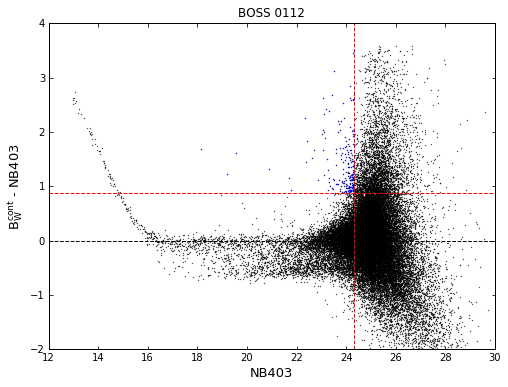

In [65]:
fig = plt.figure()

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.scatter(NB_1.standard_mag.data, bw_sub_nb, color = 'k', s=0.1)
ax1.scatter(x_nbv,y_diff, color = 'b', s=0.1)

ax1.set_xlim([12,30])
ax1.set_ylim([-2,4])

ax1.axhline(0, color='k', linestyle='--', linewidth = 1)
ax1.axhline(0.87, color='r', linestyle='--', linewidth = 1)
ax1.axvline(24.3, color='r', linestyle='--', linewidth = 1)

ax1.set_xlabel('NB403',fontdict={'weight': 'normal', 'size': 13})
ax1.set_ylabel('$\mathregular{B_W^{cont}}$ - NB403',fontdict={'weight': 'normal', 'size': 13})


ax2=ax1.twinx()
ax3=ax1.twiny()

ax3.set_xlim([12,30])
ax2.set_ylim([-2,4])

ax3.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

#ax3.set_xlabel('Flux',fontdict={'weight': 'normal', 'size': 13})
#ax2.set_ylabel('EW',fontdict={'weight': 'normal', 'size': 13})

#ax3.semilogx()

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.title('BOSS 0112')
plt.show()

<Figure size 432x288 with 0 Axes>

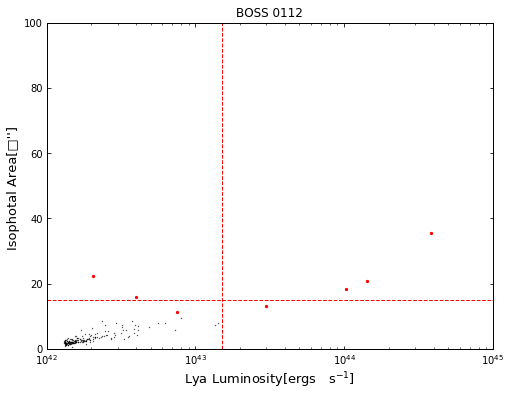

In [66]:
fig = plt.figure()
fig, ax1 = plt.subplots(figsize=(8, 6))


ax1.semilogx()
ax1.scatter(NB_2.luminosity,NB_2.ISOAREAF_IMAGE*(0.0625), color = 'k', s=0.1)
ax1.scatter(lya.luminosity,lya.ISOAREAF_IMAGE*(0.0625),color = 'r', s=5)
ax1.axhline(15, color='r', linestyle='--', linewidth = 1)
ax1.axvline(1.5e43, color='r', linestyle='--', linewidth = 1)
ax1.set_xlabel('Lya Luminosity[$\mathregular{ergs \quad s^{-1}}$]',fontdict={'weight': 'normal', 'size': 13})
ax1.set_ylabel('Isophotal Area[□\'\'] ',fontdict={'weight': 'normal', 'size': 13})
ax1.set_xlim([1e42,1e45])
ax1.set_ylim([0,100])


ax2=ax1.twinx()
ax3=ax1.twiny()

ax3.semilogx()
ax3.set_xlim([1e42,1e45])
ax2.set_ylim([0,100])

ax3.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

plt.title('BOSS 0112')
plt.show()

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:251: UserWarning:

The following kwargs were not used by contour: 'lw'

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning:

The following kwargs were not used by contour: 'lw'

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version



[0, 8500, 0, 7400]

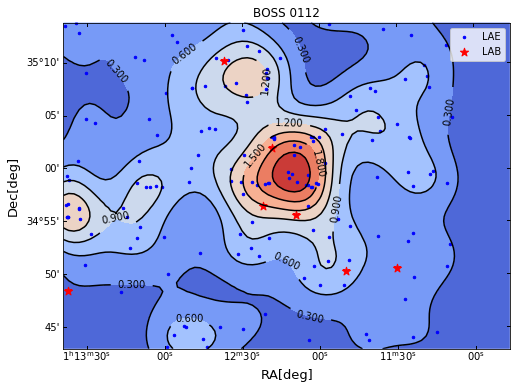

In [67]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection=wcs1)

cfset = ax.contourf(xx, yy, f, cmap='coolwarm', lw=1)
cset = ax.contour(xx, yy, f, colors='k', lw=1)

ax.scatter(NB_2.X_IMAGE.data.obj, NB_2.Y_IMAGE.data.obj, marker='.', color='blue', s=25, label='LAE')
ax.scatter(lya.X_IMAGE.data.obj, lya.Y_IMAGE.data.obj, marker='*', color='r', s=75, label='LAB')
ax.legend()

ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('RA[deg]',fontdict={'weight': 'normal', 'size': 13})
ax.set_ylabel('Dec[deg]',fontdict={'weight': 'normal', 'size': 13})

plt.title('BOSS 0112')

plt.axis([xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]])

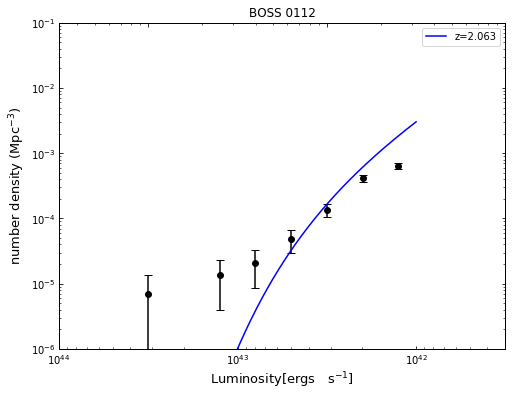

In [68]:
fig,ax1 = plt.subplots(figsize=(8, 6))
ax1.semilogx()
ax1.semilogy()

ax1.scatter(lumi_func[0], lumi_func[1], color = 'black', edgecolors='black', marker='o', s=35)
ax1.errorbar(lumi_func[0], lumi_func[1], fmt='None', yerr=error, ecolor='black', capsize=4)
ax1.plot(xvals, LuminoFunc(xvals, phi_star0, L_star0, alpha0), color='b', label='z=2.063')

ax1.set_xlim(1e44,10**(41.5))
ax1.set_ylim(10e-7,10e-2)

ax1.invert_xaxis()

ax2=ax1.twinx()
ax3=ax1.twiny()

ax3.semilogx()
ax2.semilogy()
ax3.set_xlim(1e44,10**(41.5))
ax2.set_ylim(10e-7,10e-2)

ax3.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

plt.title('BOSS 0112')
ax1.set_xlabel('Luminosity[$\mathregular{ergs \quad s^{-1}}$]',fontdict={'weight': 'normal', 'size': 13})
ax1.set_ylabel('number density ($\mathregular{Mpc^{-3}}$)',fontdict={'weight': 'normal', 'size': 13})
ax1.legend()

In [69]:
max_array=[]
min_array=[]
for i in range(len(f1)):
    max_array.append(max(f1[i]))
    min_array.append(min(f1[i]))
print(max(max_array))
print(min(min_array))

max_overdensity=math.ceil(max(max_array))
min_overdensity=math.floor(min(min_array))
print(max_overdensity)
print(min_overdensity)

blob=pd.DataFrame(columns = ['density'])
for i in range(len(lya)):
    new={'density':f1[int((lya.Y_IMAGE.data.obj[i]/100)),int((lya.X_IMAGE.data.obj[i]/100))]}
    blob=blob.append(new,ignore_index=True)
    


12.70678072302816
-0.9954057289993617
13
-1


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Series.data is deprecated and will be removed in a future version



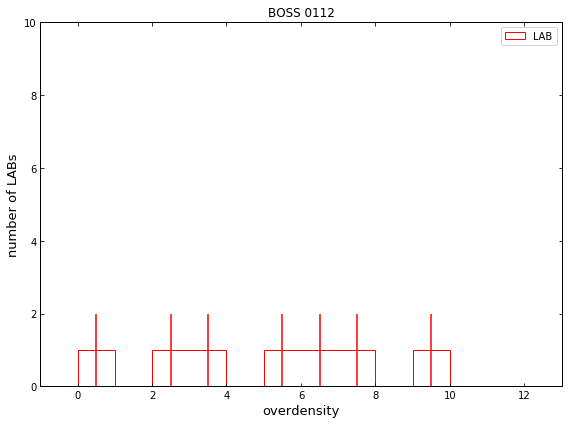

In [70]:
binwidth = 1

x = np.arange(min_overdensity,max_overdensity,1)
y = np.histogram(blob['density'], bins=np.arange(-1,max_overdensity+1))[0]

X = np.delete(np.vstack([x, y]), np.where(y==0) ,axis=1)
error = np.sqrt(X[1])

fig,ax1 = plt.subplots(figsize=(8, 6))

ax1.hist(blob['density'], histtype='step', bins=np.arange(-1,max_overdensity+1), color='r')
ax1.legend(['LAB'])
ax1.errorbar(X[0]+0.5, X[1], fmt='None', yerr=error, ecolor='r')
ax1.set_xlabel('overdensity',fontdict={'weight': 'normal', 'size': 13})
ax1.set_ylabel('number of LABs',fontdict={'weight': 'normal', 'size': 13})


#[$\mathregular{arcmin^{-1} \quad △z^{-1}}$]

ax1.set_xlim(min_overdensity,max_overdensity)
ax1.set_ylim(0,10)


ax2=ax1.twinx()
ax3=ax1.twiny()

ax3.set_xlim(min_overdensity,max_overdensity)
ax2.set_ylim(0,10)

ax3.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])


plt.title('BOSS 0112')
plt.tight_layout()
plt.show()

In [71]:
print(lya)

     X_IMAGE    Y_IMAGE  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER  \
0    85.6388  1300.6395    18.406004    34.806180   0.924956      1.450588   
1  5382.0918  1770.2578    17.957921    34.838359  33.011860      8.661927   
2  6356.0068  1842.9869    17.875496    34.843151   1.734542      1.985991   
3  4420.9463  3032.5698    18.038961    34.926219  23.786360      7.352682   
4  3805.6992  3248.4016    18.091033    34.941307  88.293880     14.165800   
5  3967.5396  4565.5010    18.077074    35.032748   6.894901      3.958821   
6  3050.9314  6518.5649    18.154570    35.168493   0.470186      1.034713   

   MAG_APER  MAGERR_APER  FLAGS  NITER_MODEL  ISOAREA_IMAGE  ISOAREAF_IMAGE  \
0    0.0847       1.7031      0           34            156             254   
1   -3.7967       0.2850      0           64            298             334   
2   -0.5980       1.2434      2           43            156             183   
3   -3.4408       0.3357      0           26            259

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will 

x_image: 85.6388 

y_image: 1300.6395 

RA: 18.4060038 

DEC: 34.8061797 

continuum_bw_magnitude 26.25713930209495 

surface_brightness: 4.1972102703215357e-16 



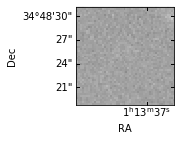

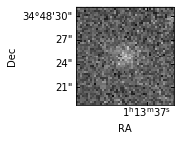

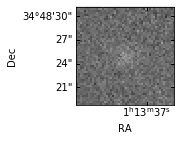

In [72]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[0],lya.Y_IMAGE.data.obj[0],25)

print('x_image:',lya.X_IMAGE.data.obj[0],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[0],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[0],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[0],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[0],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[0],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[0],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[0],'\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



x_image: 5382.0918 

y_image: 1770.2578 

RA: 17.9579206 

DEC: 34.838359000000004 

continuum_bw_magnitude 20.511123980664742 

surface_brightness: 4.367925171796288e-14 



/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Series.data is deprecated and will

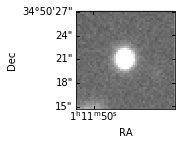

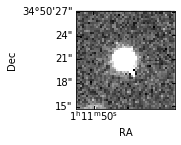

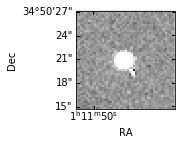

In [73]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[1],lya.Y_IMAGE.data.obj[1],25)

print('x_image:',lya.X_IMAGE.data.obj[1],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[1],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[1],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[1],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[1],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[1],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[1],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[1],'\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will 

x_image: 6356.0068 

y_image: 1842.9869 

RA: 17.875495800000003 

DEC: 34.843151 

continuum_bw_magnitude 23.963439988037216 

surface_brightness: 3.470886821958568e-15 



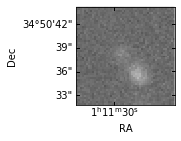

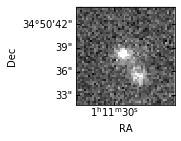

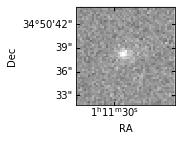

In [74]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[2],lya.Y_IMAGE.data.obj[2],25)

print('x_image:',lya.X_IMAGE.data.obj[2],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[2],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[2],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[2],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[2],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[2],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[2],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[2],'\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



x_image: 6356.0068 

y_image: 1842.9869 

RA: 17.875495800000003 

DEC: 34.843151 

continuum_bw_magnitude 23.963439988037216 

surface_brightness: 3.470886821958568e-15 



/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Series.data is deprecated and will

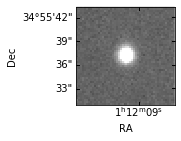

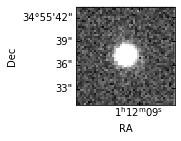

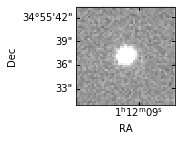

In [75]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[3],lya.Y_IMAGE.data.obj[3],25)

print('x_image:',lya.X_IMAGE.data.obj[2],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[2],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[2],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[2],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[2],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[2],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[2],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[2],'\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will 

x_image: 6356.0068 

y_image: 1842.9869 

RA: 17.875495800000003 

DEC: 34.843151 

continuum_bw_magnitude 23.963439988037216 

surface_brightness: 3.470886821958568e-15 



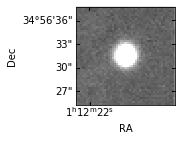

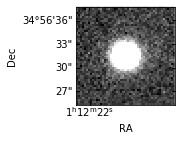

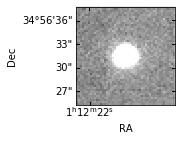

In [76]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[4],lya.Y_IMAGE.data.obj[4],25)

print('x_image:',lya.X_IMAGE.data.obj[2],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[2],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[2],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[2],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[2],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[2],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[2],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[2],'\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will 

x_image: 6356.0068 

y_image: 1842.9869 

RA: 17.875495800000003 

DEC: 34.843151 

continuum_bw_magnitude 23.963439988037216 

surface_brightness: 3.470886821958568e-15 



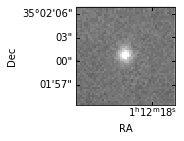

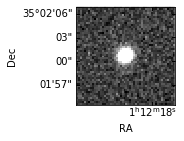

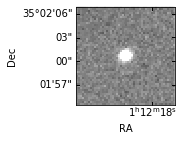

In [77]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[5],lya.Y_IMAGE.data.obj[5],25)

print('x_image:',lya.X_IMAGE.data.obj[2],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[2],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[2],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[2],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[2],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[2],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[2],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[2],'\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will 

x_image: 6356.0068 

y_image: 1842.9869 

RA: 17.875495800000003 

DEC: 34.843151 

continuum_bw_magnitude 23.963439988037216 

surface_brightness: 3.470886821958568e-15 



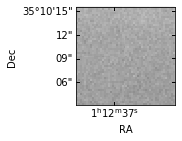

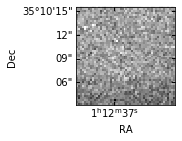

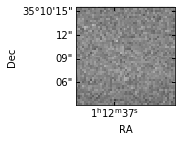

In [78]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[6],lya.Y_IMAGE.data.obj[6],25)

print('x_image:',lya.X_IMAGE.data.obj[2],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[2],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[2],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[2],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[2],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[2],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[2],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[2],'\n')

In [79]:
show_nebula(data,data2,datacut,lya.X_IMAGE.data.obj[28],lya.Y_IMAGE.data.obj[28],25)

print('x_image:',lya.X_IMAGE.data.obj[2],'\n')
print('y_image:',lya.Y_IMAGE.data.obj[2],'\n')
print('RA:',lya.ALPHA_J2000.data.obj[2],'\n')
print('DEC:',lya.DELTA_J2000.data.obj[2],'\n')
#print('bw_magnitude:',lya.mag_bw.data.obj[2],'\n')
#print('nb_magnitude',lya.mag_nb.data.obj[2],'\n')
print('continuum_bw_magnitude',lya.cont_bw.data.obj[2],'\n')
print('surface_brightness:',lya.surface_brightness.data.obj[2],'\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



IndexError: index 28 is out of bounds for axis 0 with size 7

In [ ]:
with open("BOSS0112_coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=blue dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(lya)):
        txtfile.write('circle(')
        txtfile.write(str(lya.ALPHA_J2000.data.obj[i]))
        txtfile.write(',')
        txtfile.write(str(lya.DELTA_J2000.data.obj[i]))
        txtfile.write(',2.821")\n')

In [ ]:
rms_nb=[0.00525,0.00499,0.00515]
rms_bw=[0.0560,0.0514,0.0593]


In [ ]:
mag_noise_nb=[]
mag_noise_bw=[]
for i in range(len(rms_bw)):
    mag_noise_nb.append(np.log(rms_nb[i])+zp_nb)
    mag_noise_bw.append(np.log(rms_bw[i])+zp_bw)


In [ ]:
flux_nb_noise=[]
flux_bw_noise=[]

for i in range(len(rms_bw)):
    flux_nb_noise.append(calculate_flux(mag_noise_nb[i],4030,45))
    flux_bw_noise.append(calculate_flux(mag_noise_bw[i],4135,1287))

In [ ]:
xx=[]
for i in range(len(rms_bw)):
    xx.append(calculate_continuum_flux_density(flux_bw_noise[i],flux_nb_noise[i],1278,45))
    
print(xx)

In [ ]:
distance=math.sqrt(2.27e43/(1e-15*4*math.pi))

In [ ]:
error_lumi=[]
for i in range(len(xx)):
    error_lumi.append(xx[i]*4*math.pi*distance**2)

In [ ]:
print(error_lumi)

In [80]:
L_NB2=len(NB_2)
with open("LAE0112NB.cat",'w+',newline='') as txtfile:
    
    txtfile.write(str(NB_2[0:L_NB2]))

In [ ]:
y_lower_limit=[]
y_upper_limit=[]
x_lower_limit=[]
x_upper_limit=[]

for i in range(len(lya)):
    y_lower_limit.append(int(lya.Y_IMAGE.data.obj[i])-50)
    y_upper_limit.append(int(lya.Y_IMAGE.data.obj[i])+50)
    x_lower_limit.append(int(lya.X_IMAGE.data.obj[i])-50)
    x_upper_limit.append(int(lya.X_IMAGE.data.obj[i])+50)

In [ ]:
data_lya1_bw=data[y_lower_limit[0]:y_upper_limit[0], x_lower_limit[0]:x_upper_limit[0]]*0.01

In [ ]:
hdu = fits.PrimaryHDU(data_lya1_bw)
hdu.header=header
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-1_bw.fits')

In [ ]:
data_lya1_nb=data2[y_lower_limit[0]:y_upper_limit[0], x_lower_limit[0]:x_upper_limit[0]]

In [ ]:
hdu = fits.PrimaryHDU(data_lya1_nb)
hdu.header=header2
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-1_nb.fits')

In [ ]:
data_lya2_bw=data[y_lower_limit[1]:y_upper_limit[1], x_lower_limit[1]:x_upper_limit[1]]

In [ ]:
hdu = fits.PrimaryHDU(data_lya2_bw)
hdu.header=header
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-2_bw.fits')

In [ ]:
data_lya2_nb=data2[y_lower_limit[1]:y_upper_limit[1], x_lower_limit[1]:x_upper_limit[1]]

In [ ]:
hdu = fits.PrimaryHDU(data_lya2_nb)
hdu.header=header2
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-2_nb.fits')

In [ ]:
data_lya3_bw=data[y_lower_limit[2]:y_upper_limit[2], x_lower_limit[2]:x_upper_limit[2]]

In [ ]:
hdu = fits.PrimaryHDU(data_lya3_bw)
hdu.header=header
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-3_bw.fits')

In [ ]:
data_lya3_nb=data2[y_lower_limit[2]:y_upper_limit[2], x_lower_limit[2]:x_upper_limit[2]]

In [ ]:
hdu = fits.PrimaryHDU(data_lya3_nb)
hdu.header=header2
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-3_nb.fits')

In [ ]:
data_lya4_bw=data[y_lower_limit[3]:y_upper_limit[3], x_lower_limit[3]:x_upper_limit[3]]
hdu = fits.PrimaryHDU(data_lya4_bw)
hdu.header=header
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-4_bw.fits')

In [ ]:
data_lya4_nb=data2[y_lower_limit[3]:y_upper_limit[3], x_lower_limit[3]:x_upper_limit[3]]
hdu = fits.PrimaryHDU(data_lya4_nb)
hdu.header=header2
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-4_nb.fits')

In [ ]:
data_lya5_bw=data[y_lower_limit[4]:y_upper_limit[4], x_lower_limit[4]:x_upper_limit[4]]
hdu = fits.PrimaryHDU(data_lya5_bw)
hdu.header=header
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-5_bw.fits')

In [ ]:
data_lya5_nb=data2[y_lower_limit[4]:y_upper_limit[4], x_lower_limit[4]:x_upper_limit[4]]
hdu = fits.PrimaryHDU(data_lya5_nb)
hdu.header=header2
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-5_nb.fits')

In [ ]:
data_lya6_bw=data[y_lower_limit[5]:y_upper_limit[5], x_lower_limit[5]:x_upper_limit[5]]
hdu = fits.PrimaryHDU(data_lya6_bw)
hdu.header=header
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-6_bw.fits')

In [ ]:
data_lya6_nb=data2[y_lower_limit[5]:y_upper_limit[5], x_lower_limit[5]:x_upper_limit[5]]
hdu = fits.PrimaryHDU(data_lya6_nb)
hdu.header=header2
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-6_nb.fits')

In [ ]:
data_lya7_bw=data[y_lower_limit[6]:y_upper_limit[6], x_lower_limit[6]:x_upper_limit[6]]
hdu = fits.PrimaryHDU(data_lya7_bw)
hdu.header=header
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-7_bw.fits')

In [ ]:
data_lya7_nb=data2[y_lower_limit[6]:y_upper_limit[6], x_lower_limit[6]:x_upper_limit[6]]
hdu = fits.PrimaryHDU(data_lya7_nb)
hdu.header=header2
hdul = fits.HDUList([hdu])
hdul.writeto('BOSS0112-7_nb.fits')

In [ ]:
#NB sigma

In [ ]:
data_bg_nb=data2[1000:2000,1000:2000]
data_pixel=[]
for i in range(len(data_bg_nb)):
    for j in range(len(data_bg_nb[0])):
        data_pixel.append(data_bg_nb[i][j])  

In [ ]:
data_pixel=sigma_clip(data_pixel, sigma=3, iters=10)

In [ ]:
pixel_max=data_bg_nb.max()
pixel_min=data_bg_nb.min()

binwidth=(pixel_max-pixel_min)/500

print(pixel_max)
print(pixel_min)
print(binwidth)

In [ ]:
pixel_x=np.arange(pixel_min, pixel_max, binwidth)

In [ ]:
y_pixel=np.histogram(data_pixel, bins=pixel_x)[0]

In [ ]:
yy_pixel=np.histogram(data_pixel, bins=pixel_x)[0]
xx_pixel=np.histogram(data_pixel, bins=pixel_x)[1]
xx_pixel=list(xx_pixel)
del xx_pixel[0]
print(len(xx_pixel))

In [ ]:
fig,ax = plt.subplots()
plt.scatter(xx_pixel, yy_pixel, color = 'black', edgecolors='black', marker='o', s=35)

ax.set_xlim(-0.05,0.07)

#果然是高斯！啊哈哈哈哈！

In [ ]:
sky_sigma=np.std(data_pixel)

In [ ]:
lamda_bw=4135
lamda_nb=4030
delta_bw=1278
delta_nb=45

In [ ]:
mag_nb=-2.5*np.log10(sky_sigma)+22.833
flux_nu_nb=10**(-(mag_nb+48.6)/2.5)
flux_lamda_nb=flux_nu_nb*const.c.to(u.AA/u.second).value/(lamda_nb**2)
flux_nb=flux_lamda_nb*delta_nb*u.erg/(u.second*(u.cm**2))
sb=flux_nb/0.25/0.25
print(sb)

In [ ]:
#BW sigma

In [ ]:
data_bg_bw=data[1000:5000,1000:5000]
data_pixel=[]
for i in range(len(data_bg_bw)):
    for j in range(len(data_bg_bw[0])):
        data_pixel.append(data_bg_bw[i][j]) 

In [ ]:
data_pixel=sigma_clip(data_pixel, sigma=3, iters=10)

In [ ]:
pixel_max=data_bg_nb.max()
pixel_min=data_bg_nb.min()

binwidth=(pixel_max-pixel_min)/500

print(pixel_max)
print(pixel_min)
print(binwidth)

In [ ]:
pixel_x=np.arange(pixel_min, pixel_max, binwidth)

In [ ]:
y_pixel=np.histogram(data_pixel, bins=pixel_x)[0]

In [ ]:
yy_pixel=np.histogram(data_pixel, bins=pixel_x)[0]
xx_pixel=np.histogram(data_pixel, bins=pixel_x)[1]
xx_pixel=list(xx_pixel)
del xx_pixel[0]
print(len(xx_pixel))

In [ ]:
fig,ax = plt.subplots()
plt.scatter(xx_pixel, yy_pixel, color = 'black', edgecolors='black', marker='o', s=35)

ax.set_xlim(-0.05,0.5)

#果然是高斯！啊哈哈哈哈！

In [ ]:
sky_sigma_bw=np.std(data_pixel)
print(sky_sigma_bw)

In [ ]:
print(index_nb)

In [ ]:
index_nb_exclude=index_nb[0].tolist()

In [ ]:
no_detection=BOSS_NB.drop(index_nb_exclude).copy()

In [ ]:
no_detection_candi=no_detection.drop(no_detection[no_detection.ISOAREAF_IMAGE< 15/0.0625].index).copy()

In [ ]:
no_detection_candi2=no_detection_candi.drop(no_detection_candi[no_detection_candi.standard_mag > 24.3].index).copy()

In [ ]:
no_detection_candi3=no_detection_candi2.drop(no_detection_candi2[no_detection_candi2.standard_mag<16].index).copy()

In [ ]:
no_detection_candi4=no_detection_candi3.drop(no_detection_candi3[no_detection_candi3.ISOAREAF_IMAGE>1000].index).copy()

In [ ]:
no_detection_candi4=no_detection_candi4.reset_index(drop=True)

In [ ]:
print(no_detection_candi4)

In [ ]:
bw_coord=[]
for i in range(len(no_detection_candi4)):
    a=no_detection_candi4.X_IMAGE.data.obj[i]-round(math.sqrt(no_detection_candi3.ISOAREAF_IMAGE.data.obj[i]))
    b=no_detection_candi4.X_IMAGE.data.obj[i]+round(math.sqrt(no_detection_candi3.ISOAREAF_IMAGE.data.obj[i]))
    c=no_detection_candi4.Y_IMAGE.data.obj[i]-round(math.sqrt(no_detection_candi3.ISOAREAF_IMAGE.data.obj[i]))
    d=no_detection_candi4.Y_IMAGE.data.obj[i]+round(math.sqrt(no_detection_candi3.ISOAREAF_IMAGE.data.obj[i]))
    a=int(a)
    b=int(b)
    c=int(c)
    d=int(d)
    bw_coord.append([a,b,c,d])

In [ ]:
sum_count=[]
for i in range(len(no_detection_candi4)):
    gg=data[bw_coord[i][0]:bw_coord[i][1],bw_coord[i][2]:bw_coord[i][3]]
    sum_count.append(gg.sum())

'''
for i in range(len(sum_count)):
    if sum_count[i]<=0:
        sum_count[i]=100000
'''
print(sum_count)


In [ ]:
no_detection_candi4=pd.concat([no_detection_candi4,DataFrame(sum_count)],axis=1)
no_detection_candi4.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','sum_count']



In [ ]:
print(no_detection_candi4)

In [ ]:
no_detection_candi5=no_detection_candi4.drop(no_detection_candi4[no_detection_candi4.sum_count<=0].index).copy()
no_detection_candi5=no_detection_candi5.reset_index(drop=True)

In [ ]:
print(no_detection_candi5)


In [ ]:
bw_mag_nodetection=[]
for i in range(len(no_detection_candi5)):
    bw_mag_nodetection.append(-2.5*math.log(no_detection_candi5.sum_count.data.obj[i],10)+zp_bw)
print(bw_mag_nodetection)

In [ ]:
no_detection_candi5=pd.concat([no_detection_candi5,DataFrame(bw_mag_nodetection)],axis=1)
no_detection_candi5.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','sum_count','mag_bw']
print(no_detection_candi5)

In [ ]:
flux_bw=[]
for i in range(len(no_detection_candi5)):
    flux_bw.append(calculate_flux(no_detection_candi5.mag_bw.data.obj[i],4135,1278))

In [ ]:
no_detection_candi5=pd.concat([no_detection_candi5,DataFrame(flux_bw)],axis=1)
no_detection_candi5.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','sum_count','mag_bw','flux_bw']


In [ ]:
print(no_detection_candi5)

In [ ]:
luminosity=[]
for i in range(len(no_detection_candi5)):
    a=calculate_continuum_subtracted_line_flux(no_detection_candi5.flux_bw.data.obj[i],no_detection_candi5.flux_nb[i],1278,45)
    luminosity.append(4*math.pi*distance**2*a)
    
print(luminosity)



In [ ]:
no_detection_candi5=pd.concat([no_detection_candi5,DataFrame(luminosity)],axis=1)
no_detection_candi5.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','sum_count','mag_bw','flux_bw','luminosity']


In [204]:
print(no_detection_candi5)

NameError: name 'no_detection_candi5' is not defined

In [205]:
no_detection_candi6=no_detection_candi5.drop(no_detection_candi5[no_detection_candi5.luminosity<1.5e43].index).copy()
no_detection_candi6=no_detection_candi6.reset_index(drop=True)

NameError: name 'no_detection_candi5' is not defined

In [206]:
print(no_detection_candi6)

NameError: name 'no_detection_candi6' is not defined

In [207]:
show_nebula(data,data2,datacut,no_detection_candi6.X_IMAGE.data.obj[0],no_detection_candi6.Y_IMAGE.data.obj[0],25)

NameError: name 'no_detection_candi6' is not defined

In [208]:
show_nebula(data,data2,datacut,no_detection_candi6.X_IMAGE.data.obj[1],no_detection_candi6.Y_IMAGE.data.obj[1],25)

NameError: name 'no_detection_candi6' is not defined

In [209]:
show_nebula(data,data2,datacut,no_detection_candi6.X_IMAGE.data.obj[2],no_detection_candi6.Y_IMAGE.data.obj[2],25)

NameError: name 'no_detection_candi6' is not defined

In [210]:
show_nebula(data,data2,datacut,no_detection_candi6.X_IMAGE.data.obj[3],no_detection_candi6.Y_IMAGE.data.obj[3],25)

NameError: name 'no_detection_candi6' is not defined

In [76]:
print(len(NB_2))

188
